In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import array
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
import seaborn as sns
from statistics import mode

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem
from plots import *
from PM import *
%matplotlib inline

In [2]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/survey_Lam72.csv'
FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/samples_combined.csv'
#FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

################################################### Calibrated data ##########################################

FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/proefhoeve_421S_calibrated.csv'
FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/transects/proefhoeve_421S_transect_calibrated.csv'
samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/samples_merge.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0.1', 'x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph',
       'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph',
       'Unnamed: 0', 'x_clhs', 'y_clhs', 'z.1', 't.1', 'name', 'depth',
       'ph-eau', 'CEC', 'clay', 'silt', 'sand', 'TOC', 'humus', 'bd', 'vwc',
       'copeky', 'temp', 'rperm', 'iperm'],
      dtype='object')

## Preprocesingn

In [3]:
SheetsHendrickxEC(np.array([0.12, 0.25]), 20)

array([0.13352103, 0.27816881])

In [4]:
ds_c = ds.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

# Caclculate Bulk EC from HydraProbe data at 0 Hz
def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds_c.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds_c.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_c['bulk_ec_dc_hp'] = bulk_ec_dc_hp
ds_c['bulk_ec_dc_hp_t'] = SheetsHendrickxEC( ds_c.bulk_ec_dc_hp, ds_c.temp)

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)

ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

# Caclculate Aparent Bulk EC from EMI at 0 Hz in S/m
EC_columns = ['HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1'] 
for col in EC_columns:
    EC_DC = []
    for i in range(len(ds_c[col].values)):
        res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_c[col][i]/1000), bounds=[(0, 1)])
        EC_DC.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

    ds_c[col+'_DC'] = EC_DC
    ds_c[col+'_DC_t'] = SheetsHendrickxEC(ds_c[col+'_DC'], ds_c.temp)

ds_c

,Unnamed: 0.1,x,y,z,t,HCP0.5,PRP0.6,HCP1.0,PRP1.1,HCP2.0,...,PRP0.6_DC,PRP0.6_DC_t,HCP1.0_DC,HCP1.0_DC_t,PRP1.1_DC,PRP1.1_DC_t,HCP2.0_DC,HCP2.0_DC_t,PRP2.1_DC,PRP2.1_DC_t
0,2647,107720.422,183327.165,26.201000,33302.50,49.708763,47.845835,37.843774,52.474800,46.928091,...,0.04510,0.044252,0.03554,0.034872,0.04954,0.048609,0.04422,0.043389,0.03679,0.036098
1,9662,107755.083,183330.802,26.855331,34836.56,25.743303,21.675973,36.071440,33.225212,48.799794,...,0.02015,0.020867,0.03385,0.035055,0.03113,0.032238,0.04602,0.047658,0.03829,0.039653
2,11087,107797.240,183278.473,27.948771,35121.56,104.677606,64.175438,110.276828,101.761033,77.029971,...,0.06077,0.059993,0.10528,0.103934,0.09704,0.095799,0.07315,0.072215,0.12083,0.119285
3,9694,107763.627,183318.268,27.208957,34842.93,12.959597,13.395855,28.647371,17.018360,54.142913,...,0.01232,0.012519,0.02677,0.027203,0.01574,0.015994,0.05114,0.051967,0.03233,0.032853
4,789,107722.801,183309.348,26.679000,32930.91,60.440477,59.557356,37.877648,61.994837,47.031061,...,0.05633,0.057241,0.03557,0.036145,0.05867,0.059618,0.04432,0.045037,0.04657,0.047323
5,7232,107742.964,183330.078,26.550000,34219.71,31.530565,26.341353,33.908803,34.689163,48.990268,...,0.02458,0.024770,0.03178,0.032026,0.03253,0.032782,0.04620,0.046558,0.03497,0.035241
6,11576,107805.582,183274.029,28.650000,35219.35,108.041245,57.984582,121.282592,101.492936,81.171807,...,0.05482,0.053464,0.11594,0.113072,0.09678,0.094386,0.07715,0.075241,0.12193,0.118913
7,7909,107758.569,183312.798,27.350000,34485.90,19.401647,17.909749,32.113631,25.111111,54.003944,...,0.01658,0.017693,0.03007,0.032089,0.02341,0.024982,0.05100,0.054424,0.04053,0.043251
8,11008,107776.575,183310.642,26.990019,35105.74,56.330807,30.771741,68.962331,55.658735,63.263473,...,0.02879,0.029440,0.06538,0.066856,0.05259,0.053777,0.05989,0.061242,0.07263,0.074269
9,2627,107726.042,183318.485,26.648100,33298.53,75.268359,67.025999,50.839843,77.135054,48.706464,...,0.06351,0.065771,0.04797,0.049677,0.07325,0.075857,0.04593,0.047565,0.05486,0.056813


In [5]:
R2_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2', 'Best EC feature 10cm', 'R2 10cm', 
                                      'Best EC feature 50cm', 'R2 50cm', 'Best EC feature combined', 'R2 combined', 'R2 combined2'],
                  index=range(0, 5))

RMSE_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE', 'Best EC feature 10cm', 'RMSE 10cm', 
                                      'Best EC feature 50cm', 'RMSE 50cm', 'Best EC feature combined', 'RMSE combined', 'RMSE combined2'],
                  index=range(0, 5))

R2_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2'],
                  index=range(0, 5))

RMSE_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE'],
                  index=range(0, 5))

## Inversion of DC EMI data

100%|██████████| 30/30 [00:00<00:00, 194.81it/s]


   Finished inversion


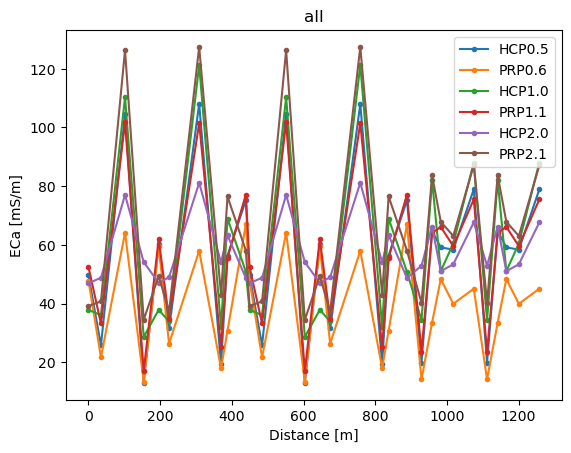

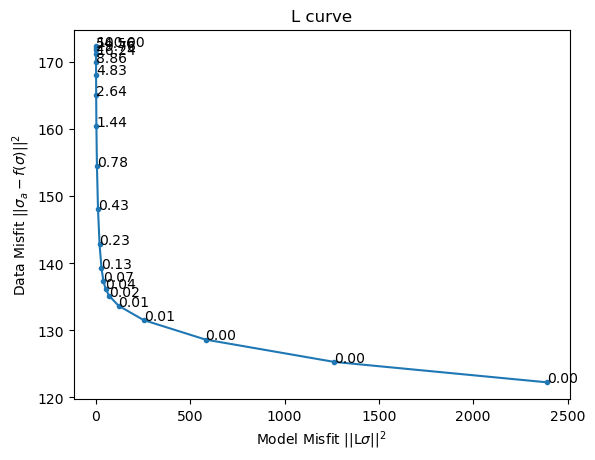

In [6]:
#depths_in = [0.1, 0.5, 0.8, 1.5]
depths_in = [0.4, 0.8]

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9e3,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)
sample_transect.show()
sample_transect.lcurve()

# Run the inversion
sample_transect.invert( alpha=0.01, njobs=-1) # FSIQ, alpha  check forwardModel='FSeq',
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds_c.iloc[:, 3:11], ds_c.iloc[:, 17:]], axis=1)

ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

## 

In [7]:
# Calculate the Bulk EC DC inverted at suitable depth based on invertion layers.
bulk_ec_dc_010 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.40'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_010.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_010'] = bulk_ec_dc_010
ds_all_10cm = ds_all.loc[ds_all['depth']==10].reset_index(drop=True)

bulk_ec_dc_050 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.80'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_050.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_050'] = bulk_ec_dc_050
ds_all_50cm = ds_all.loc[ds_all['depth']==50].reset_index(drop=True)

ds_all['bulk_ec_dc_inv'] = [ds_all.bulk_ec_dc_010[i] if ds_all.depth[i] == 10 else ds_all.bulk_ec_dc_050[i] for i in range(len(ds_all.vwc))]
ds_all['bulk_ec_dc_inv_t'] = SheetsHendrickxEC(ds_all.bulk_ec_dc_inv, ds_all.temp)

In [8]:
ds_f = ds_all[['x', 'y', 'z', 't', 'HCP0.5_DC_t', 'PRP0.6_DC_t', 'HCP1.0_DC_t',
       'PRP1.1_DC_t', 'HCP2.0_DC_t', 'PRP2.1_DC_t', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm', 'bulk_ec_hp', 'water_ec_hp_t', 'bulk_ec_dc_inv_t']]

#sns.pairplot(ds_f)

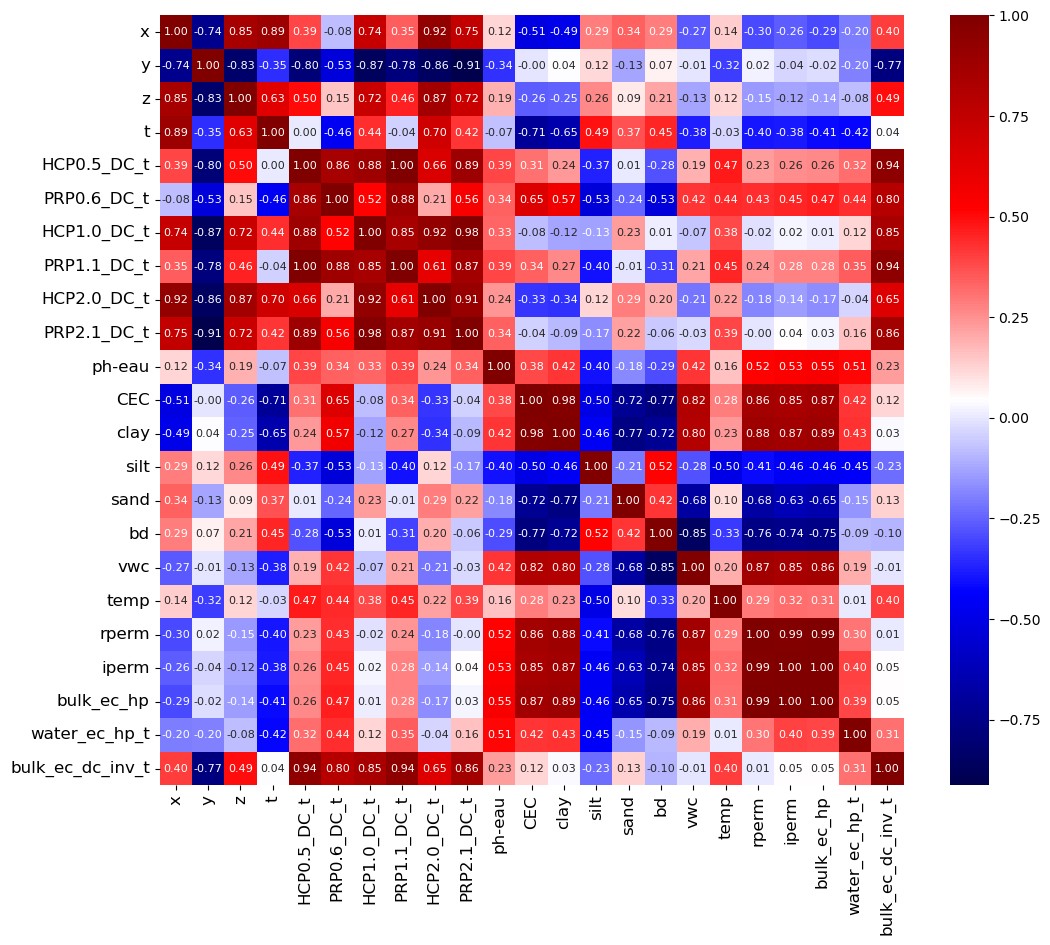

In [9]:
# Setting the figure size
plt.figure(figsize=(12, 10))

# Plotting correlation heatmap with annotations
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic", annot=True, fmt=".2f", annot_kws={"size": 8})

dataplot.tick_params(axis='both', which='major', labelsize=12)

# Rotating y-axis labels for better visualization
dataplot.set_yticklabels(dataplot.get_yticklabels(), rotation=0)

# Setting the label size for x and y axes
dataplot.set_xlabel(dataplot.get_xlabel(), fontsize=14)
dataplot.set_ylabel(dataplot.get_ylabel(), fontsize=14)

plt.show()

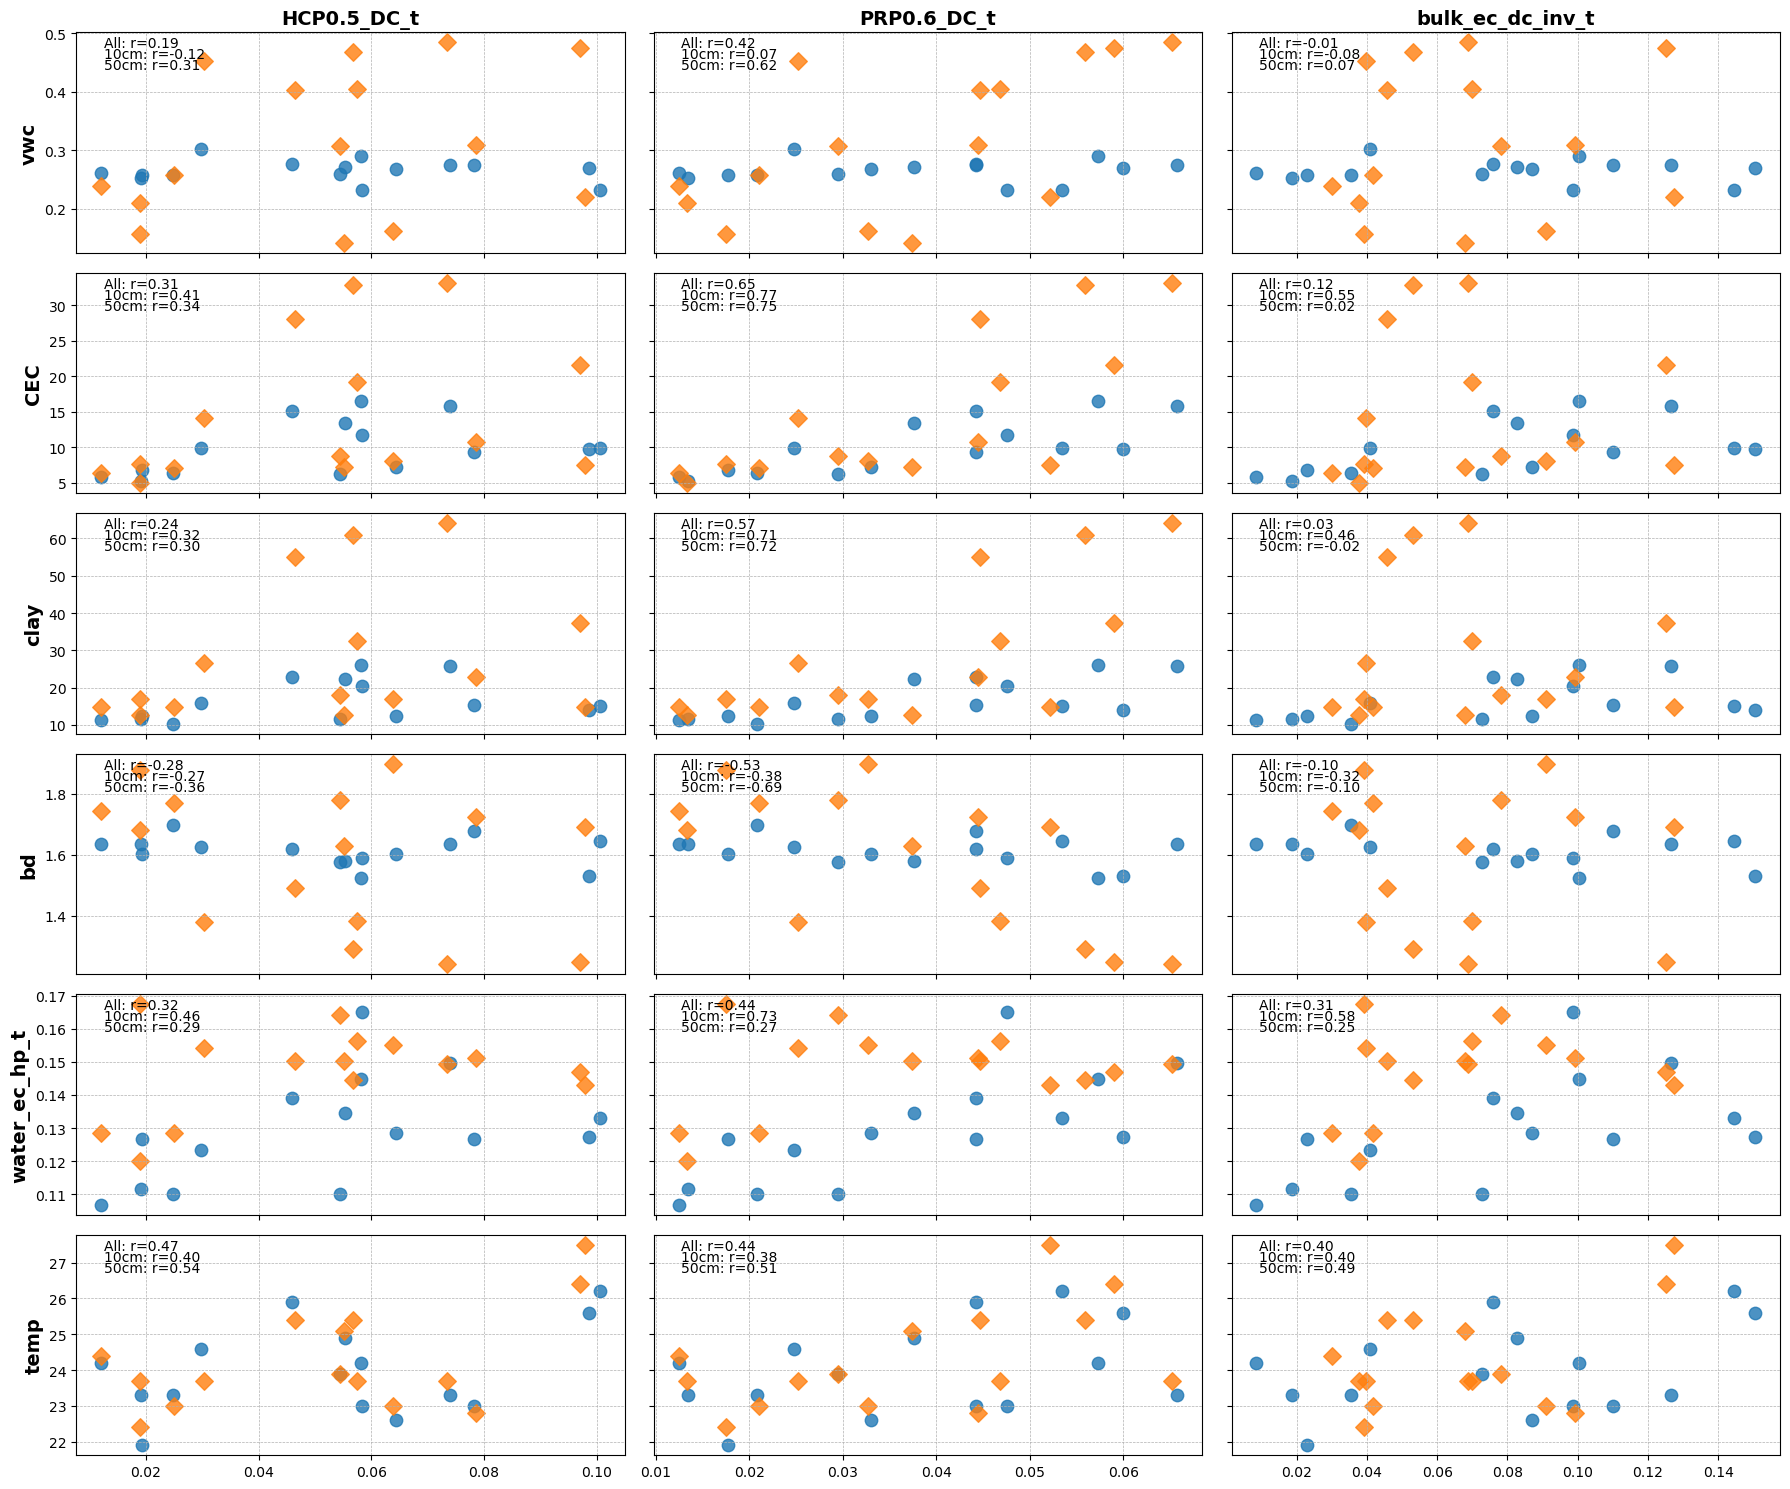

In [10]:
fig, axes = plt.subplots(6, 3, figsize=(18, 15))
ss = 80

targets = ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp_t', 'temp']
preds = ['HCP0.5_DC_t', 'PRP0.6_DC_t', 'bulk_ec_dc_inv_t']

def corr_plot(df, preds, targets):

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):

            ax = axes[target_index, pred_index]
            
            # Add grid to the subplot
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                # Calculate correlation coefficient for the specific depth
                corr = np.corrcoef(x_data.dropna(), y_data.dropna())[0, 1]

                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                    ax.text(0.05, 0.9, f'10cm: r={corr:.2f}', transform=ax.transAxes, va="center")
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')
                    ax.text(0.05, 0.85, f'50cm: r={corr:.2f}', transform=ax.transAxes, va="center")

            # Set titles for columns
            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:  # not the bottom row
                ax.set_xticklabels([])

            # Set row labels for the leftmost plots
            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:  # not the first column
                ax.set_yticklabels([])

corr_plot(ds_all, preds, targets)
plt.tight_layout()

## Deterministic modelling

In [11]:
clay_50cm = np.mean(ds_all.clay[ds_all['depth']==50])
clay_10cm = np.mean(ds_all.clay[ds_all['depth']==10])
bd_50cm = np.mean(ds_all.bd[ds_all['depth']==50])
bd_10cm = np.mean(ds_all.bd[ds_all['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_all.water_ec_hp_t[ds_all['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_all.water_ec_hp_t[ds_all['depth']==10])

# Defining minimization function to obtain water using Fu
def objective_func_wat(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec, EC):
    return (Fu(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec) - EC)**2

def calculate_water(ds, col, round_n=3):
    wat = []
    for dc in ds[col]:
        index = ds.index[ds[col] == dc][0]
        if ds.depth[index] == 50:
            res = minimize(objective_func_wat, 0.15, args=(clay_50cm, bd_50cm, 2.65, water_ec_hp_50cm_t, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])
        else:
            res = minimize(objective_func_wat, 0.15, args=(clay_10cm, bd_10cm, 2.65, water_ec_hp_10cm_t, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])            
        wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], round_n))

    r2_val = round(r2_score(ds.vwc.values, wat), round_n)
    rmse_val = round(RMSE(ds.vwc.values, wat), round_n)
    return wat, r2_val, rmse_val

HCP0.5_DC_t 0     0.046009
1     0.024865
2     0.098583
3     0.012103
4     0.058104
5     0.029748
6     0.100569
7     0.019209
8     0.054431
9     0.073993
10    0.046480
11    0.025024
12    0.096997
13    0.012052
14    0.056680
15    0.030313
16    0.097991
17    0.019002
18    0.054431
19    0.073371
20    0.018956
21    0.063898
22    0.057423
23    0.055075
24    0.078500
25    0.019117
26    0.064447
27    0.058281
28    0.055303
29    0.078166
Name: HCP0.5_DC_t, dtype: float64
wat [0.414, 0.269, 0.65, 0.156, 0.483, 0.306, 0.65, 0.222, 0.463, 0.566, 0.302, 0.183, 0.521, 0.097, 0.352, 0.215, 0.525, 0.145, 0.463, 0.426, 0.145, 0.385, 0.355, 0.344, 0.448, 0.221, 0.517, 0.484, 0.468, 0.586]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


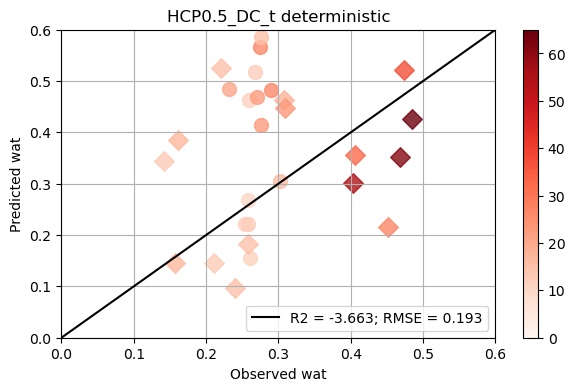

HCP1.0_DC_t 0     0.034872
1     0.035055
2     0.103934
3     0.027203
4     0.036145
5     0.032026
6     0.113072
7     0.032089
8     0.066856
9     0.049677
10    0.035229
11    0.035279
12    0.102262
13    0.027090
14    0.035259
15    0.032634
16    0.110173
17    0.031744
18    0.066856
19    0.049259
20    0.033004
21    0.081335
22    0.049444
23    0.057100
24    0.087711
25    0.033284
26    0.082033
27    0.050183
28    0.057336
29    0.087338
Name: HCP1.0_DC_t, dtype: float64
wat [0.342, 0.343, 0.65, 0.287, 0.351, 0.322, 0.65, 0.323, 0.53, 0.436, 0.243, 0.243, 0.541, 0.196, 0.243, 0.228, 0.57, 0.223, 0.53, 0.316, 0.23, 0.459, 0.317, 0.354, 0.485, 0.331, 0.604, 0.439, 0.479, 0.629]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


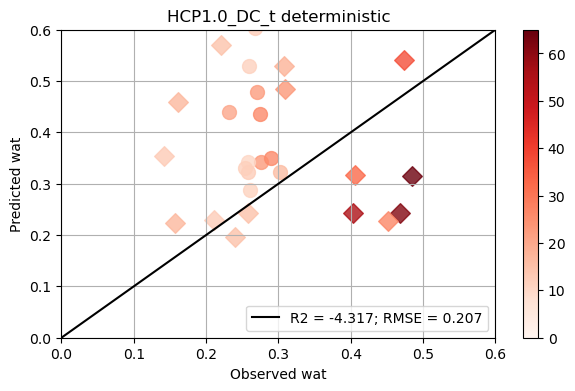

HCP2.0_DC_t 0     0.043389
1     0.047658
2     0.072215
3     0.051967
4     0.045037
5     0.046558
6     0.075241
7     0.054424
8     0.061242
9     0.047565
10    0.043833
11    0.047963
12    0.071053
13    0.051750
14    0.043933
15    0.047442
16    0.073313
17    0.053840
18    0.061242
19    0.047165
20    0.051282
21    0.065389
22    0.049465
23    0.050268
24    0.067154
25    0.051718
26    0.065950
27    0.050204
28    0.050476
29    0.066869
Name: HCP2.0_DC_t, dtype: float64
wat [0.397, 0.424, 0.557, 0.449, 0.408, 0.417, 0.572, 0.463, 0.5, 0.423, 0.288, 0.309, 0.416, 0.328, 0.289, 0.307, 0.426, 0.338, 0.5, 0.305, 0.326, 0.391, 0.317, 0.321, 0.399, 0.448, 0.525, 0.439, 0.44, 0.53]
for predicting water deterministically, the best predictor is:HCP2.0_DC_t


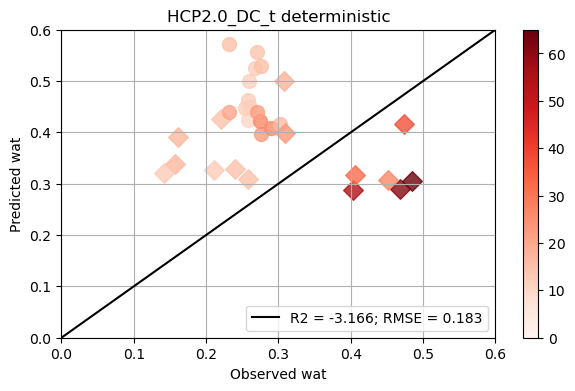

PRP0.6_DC_t 0     0.044252
1     0.020867
2     0.059993
3     0.012519
4     0.057241
5     0.024770
6     0.053464
7     0.017693
8     0.029440
9     0.065771
10    0.044706
11    0.021001
12    0.059028
13    0.012467
14    0.055838
15    0.025241
16    0.052093
17    0.017503
18    0.029440
19    0.065217
20    0.013360
21    0.032736
22    0.046805
23    0.037402
24    0.044431
25    0.013473
26    0.033017
27    0.047504
28    0.037556
29    0.044242
Name: PRP0.6_DC_t, dtype: float64
wat [0.403, 0.236, 0.494, 0.16, 0.479, 0.268, 0.458, 0.209, 0.304, 0.524, 0.293, 0.158, 0.362, 0.1, 0.348, 0.185, 0.33, 0.135, 0.304, 0.391, 0.107, 0.229, 0.304, 0.255, 0.292, 0.169, 0.329, 0.423, 0.36, 0.403]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


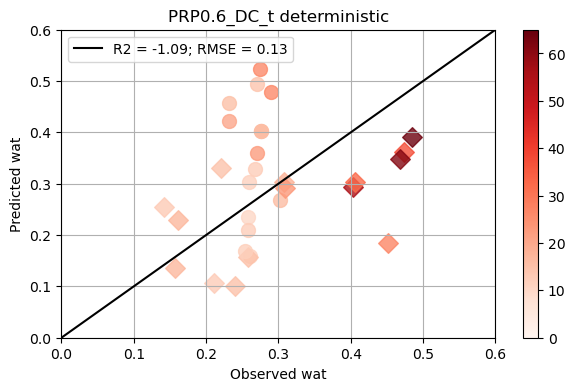

PRP1.1_DC_t 0     0.048609
1     0.032238
2     0.095799
3     0.015994
4     0.059618
5     0.032782
6     0.094386
7     0.024982
8     0.053777
9     0.075857
10    0.049107
11    0.032444
12    0.094258
13    0.015928
14    0.058157
15    0.033404
16    0.091966
17    0.024714
18    0.053777
19    0.075219
20    0.022499
21    0.063273
22    0.064334
23    0.056212
24    0.075036
25    0.022690
26    0.063816
27    0.065295
28    0.056445
29    0.074716
Name: PRP1.1_DC_t, dtype: float64
wat [0.429, 0.324, 0.65, 0.193, 0.492, 0.328, 0.65, 0.27, 0.459, 0.575, 0.315, 0.227, 0.511, 0.125, 0.358, 0.232, 0.502, 0.181, 0.459, 0.434, 0.168, 0.382, 0.387, 0.349, 0.433, 0.251, 0.514, 0.522, 0.474, 0.569]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


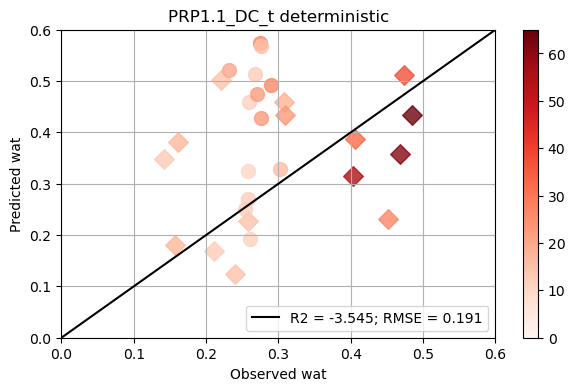

PRP2.1_DC_t 0     0.036098
1     0.039653
2     0.119285
3     0.032853
4     0.047323
5     0.035241
6     0.118913
7     0.043251
8     0.074269
9     0.056813
10    0.036468
11    0.039906
12    0.117366
13    0.032716
14    0.046163
15    0.035910
16    0.115865
17    0.042787
18    0.074269
19    0.056335
20    0.038837
21    0.082929
22    0.066059
23    0.059514
24    0.086832
25    0.039166
26    0.083641
27    0.067046
28    0.059760
29    0.086462
Name: PRP2.1_DC_t, dtype: float64
wat [0.35, 0.374, 0.65, 0.328, 0.422, 0.345, 0.65, 0.397, 0.567, 0.476, 0.249, 0.268, 0.595, 0.229, 0.3, 0.246, 0.59, 0.283, 0.567, 0.35, 0.262, 0.466, 0.394, 0.365, 0.481, 0.371, 0.612, 0.531, 0.493, 0.625]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


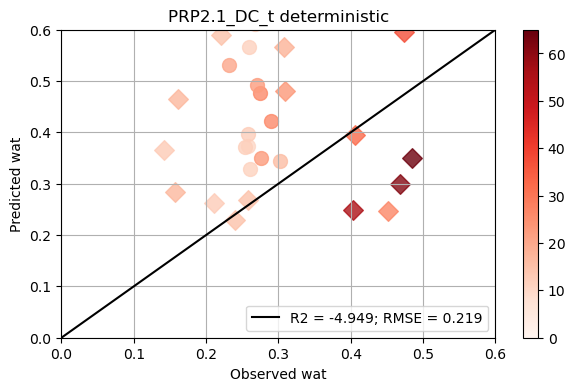

bulk_ec_dc_inv_t 0     0.075739
1     0.035397
2     0.150471
3     0.008536
4     0.100367
5     0.040803
6     0.144553
7     0.022837
8     0.072633
9     0.126653
10    0.045667
11    0.041762
12    0.125020
13    0.030085
14    0.053072
15    0.039648
16    0.127287
17    0.039282
18    0.078124
19    0.068863
20    0.037645
21    0.090902
22    0.069756
23    0.067832
24    0.099235
25    0.018765
26    0.087089
27    0.098760
28    0.082804
29    0.109995
Name: bulk_ec_dc_inv_t, dtype: float64
wat [0.574, 0.346, 0.65, 0.118, 0.65, 0.381, 0.65, 0.253, 0.559, 0.65, 0.298, 0.278, 0.622, 0.213, 0.334, 0.267, 0.63, 0.265, 0.446, 0.407, 0.256, 0.497, 0.411, 0.402, 0.53, 0.218, 0.627, 0.65, 0.608, 0.65]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


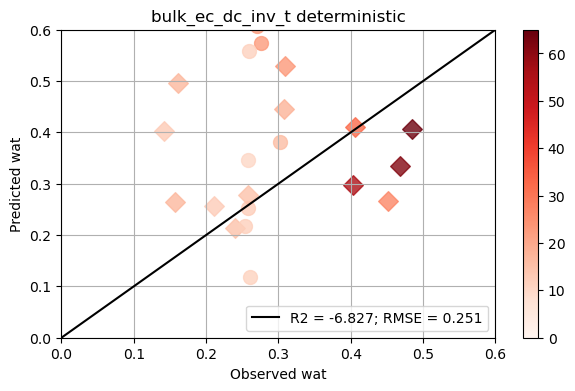

HCP0.5_DC 0     0.04689
1     0.02401
2     0.09986
3     0.01191
4     0.05718
5     0.02952
6     0.10312
7     0.01800
8     0.05323
9     0.07145
10    0.04689
11    0.02401
12    0.09986
13    0.01191
14    0.05718
15    0.02952
16    0.10312
17    0.01800
18    0.05323
19    0.07145
20    0.01846
21    0.06131
22    0.05592
23    0.05522
24    0.07500
25    0.01846
26    0.06131
27    0.05592
28    0.05522
29    0.07500
Name: HCP0.5_DC, dtype: float64
wat [0.419, 0.262, 0.65, 0.154, 0.478, 0.304, 0.65, 0.211, 0.456, 0.553, 0.419, 0.262, 0.65, 0.154, 0.478, 0.304, 0.65, 0.211, 0.456, 0.553, 0.142, 0.373, 0.348, 0.345, 0.433, 0.142, 0.373, 0.348, 0.345, 0.433]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


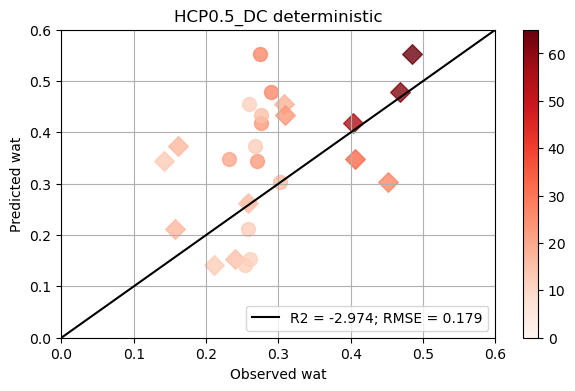

HCP1.0_DC 0     0.03554
1     0.03385
2     0.10528
3     0.02677
4     0.03557
5     0.03178
6     0.11594
7     0.03007
8     0.06538
9     0.04797
10    0.03554
11    0.03385
12    0.10528
13    0.02677
14    0.03557
15    0.03178
16    0.11594
17    0.03007
18    0.06538
19    0.04797
20    0.03214
21    0.07804
22    0.04815
23    0.05725
24    0.08380
25    0.03214
26    0.07804
27    0.04815
28    0.05725
29    0.08380
Name: HCP1.0_DC, dtype: float64
wat [0.347, 0.335, 0.65, 0.283, 0.347, 0.321, 0.65, 0.308, 0.522, 0.425, 0.347, 0.335, 0.65, 0.283, 0.347, 0.321, 0.65, 0.308, 0.522, 0.425, 0.225, 0.446, 0.31, 0.354, 0.469, 0.225, 0.446, 0.31, 0.354, 0.469]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


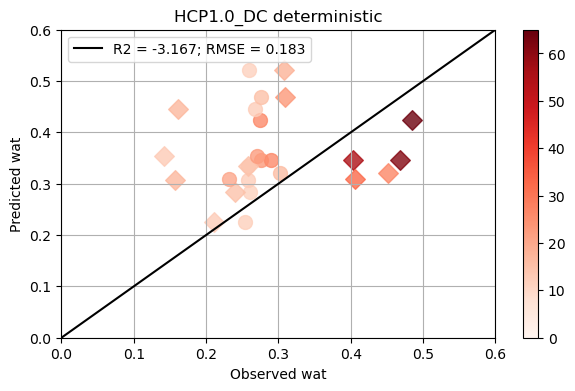

HCP2.0_DC 0     0.04422
1     0.04602
2     0.07315
3     0.05114
4     0.04432
5     0.04620
6     0.07715
7     0.05100
8     0.05989
9     0.04593
10    0.04422
11    0.04602
12    0.07315
13    0.05114
14    0.04432
15    0.04620
16    0.07715
17    0.05100
18    0.05989
19    0.04593
20    0.04994
21    0.06274
22    0.04817
23    0.05040
24    0.06416
25    0.04994
26    0.06274
27    0.04817
28    0.05040
29    0.06416
Name: HCP2.0_DC, dtype: float64
wat [0.403, 0.414, 0.561, 0.444, 0.403, 0.415, 0.581, 0.443, 0.493, 0.413, 0.403, 0.414, 0.561, 0.444, 0.403, 0.415, 0.581, 0.443, 0.493, 0.413, 0.319, 0.379, 0.31, 0.321, 0.386, 0.319, 0.379, 0.31, 0.321, 0.386]
for predicting water deterministically, the best predictor is:PRP0.6_DC_t


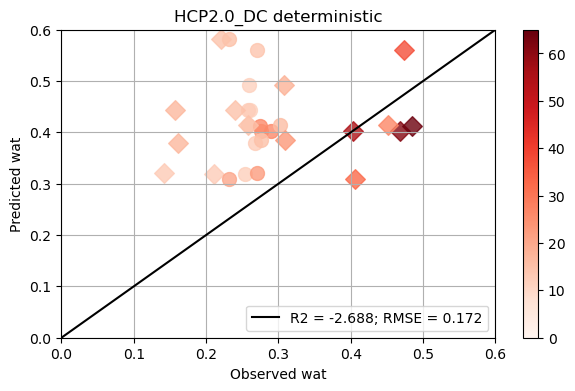

PRP0.6_DC 0     0.04510
1     0.02015
2     0.06077
3     0.01232
4     0.05633
5     0.02458
6     0.05482
7     0.01658
8     0.02879
9     0.06351
10    0.04510
11    0.02015
12    0.06077
13    0.01232
14    0.05633
15    0.02458
16    0.05482
17    0.01658
18    0.02879
19    0.06351
20    0.01301
21    0.03141
22    0.04558
23    0.03750
24    0.04245
25    0.01301
26    0.03141
27    0.04558
28    0.03750
29    0.04245
Name: PRP0.6_DC, dtype: float64
wat [0.408, 0.23, 0.498, 0.158, 0.474, 0.267, 0.465, 0.199, 0.299, 0.512, 0.408, 0.23, 0.498, 0.158, 0.474, 0.267, 0.465, 0.199, 0.299, 0.512, 0.104, 0.221, 0.297, 0.255, 0.281, 0.104, 0.221, 0.297, 0.255, 0.281]
for predicting water deterministically, the best predictor is:PRP0.6_DC


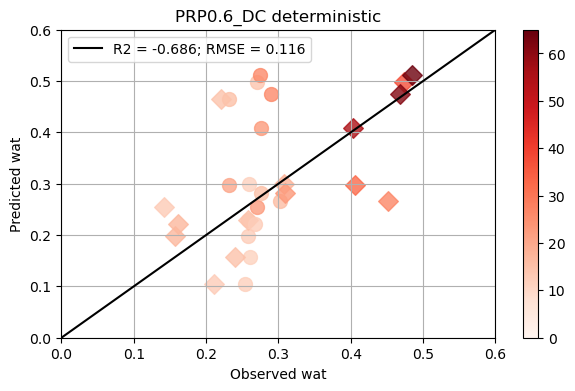

PRP1.1_DC 0     0.04954
1     0.03113
2     0.09704
3     0.01574
4     0.05867
5     0.03253
6     0.09678
7     0.02341
8     0.05259
9     0.07325
10    0.04954
11    0.03113
12    0.09704
13    0.01574
14    0.05867
15    0.03253
16    0.09678
17    0.02341
18    0.05259
19    0.07325
20    0.02191
21    0.06071
22    0.06265
23    0.05636
24    0.07169
25    0.02191
26    0.06071
27    0.06265
28    0.05636
29    0.07169
Name: PRP1.1_DC, dtype: float64
wat [0.435, 0.316, 0.65, 0.191, 0.486, 0.326, 0.65, 0.257, 0.453, 0.562, 0.435, 0.316, 0.65, 0.191, 0.486, 0.326, 0.65, 0.257, 0.453, 0.562, 0.164, 0.37, 0.379, 0.35, 0.419, 0.164, 0.37, 0.379, 0.35, 0.419]
for predicting water deterministically, the best predictor is:PRP0.6_DC


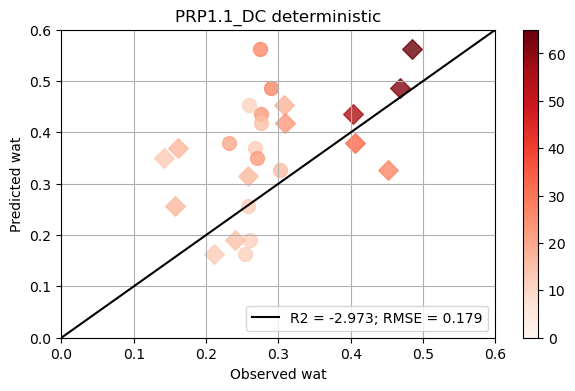

PRP2.1_DC 0     0.03679
1     0.03829
2     0.12083
3     0.03233
4     0.04657
5     0.03497
6     0.12193
7     0.04053
8     0.07263
9     0.05486
10    0.03679
11    0.03829
12    0.12083
13    0.03233
14    0.04657
15    0.03497
16    0.12193
17    0.04053
18    0.07263
19    0.05486
20    0.03782
21    0.07957
22    0.06433
23    0.05967
24    0.08296
25    0.03782
26    0.07957
27    0.06433
28    0.05967
29    0.08296
Name: PRP2.1_DC, dtype: float64
wat [0.355, 0.365, 0.65, 0.324, 0.417, 0.343, 0.65, 0.38, 0.559, 0.465, 0.355, 0.365, 0.65, 0.324, 0.417, 0.343, 0.65, 0.38, 0.559, 0.465, 0.257, 0.452, 0.387, 0.365, 0.466, 0.257, 0.452, 0.387, 0.365, 0.466]
for predicting water deterministically, the best predictor is:PRP0.6_DC


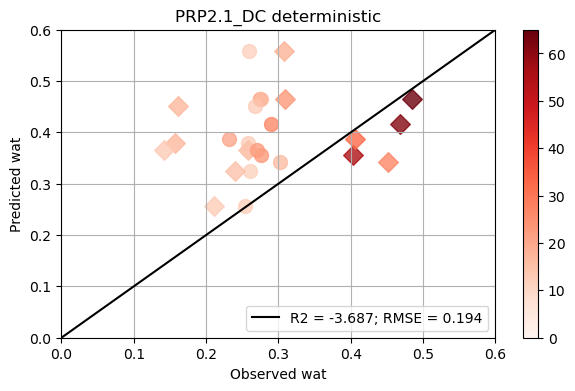

bulk_ec_dc_inv 0     0.07719
1     0.03418
2     0.15242
3     0.00840
4     0.09877
5     0.04049
6     0.14822
7     0.02140
8     0.07103
9     0.12230
10    0.04607
11    0.04007
12    0.12871
13    0.02973
14    0.05354
15    0.03861
16    0.13395
17    0.03721
18    0.07640
19    0.06706
20    0.03666
21    0.08722
22    0.06793
23    0.06801
24    0.09481
25    0.01812
26    0.08285
27    0.09476
28    0.08268
29    0.10554
Name: bulk_ec_dc_inv, dtype: float64
wat [0.581, 0.337, 0.65, 0.116, 0.65, 0.379, 0.65, 0.241, 0.551, 0.65, 0.3, 0.269, 0.634, 0.211, 0.337, 0.261, 0.65, 0.254, 0.439, 0.399, 0.251, 0.483, 0.403, 0.403, 0.513, 0.212, 0.608, 0.65, 0.607, 0.65]
for predicting water deterministically, the best predictor is:PRP0.6_DC


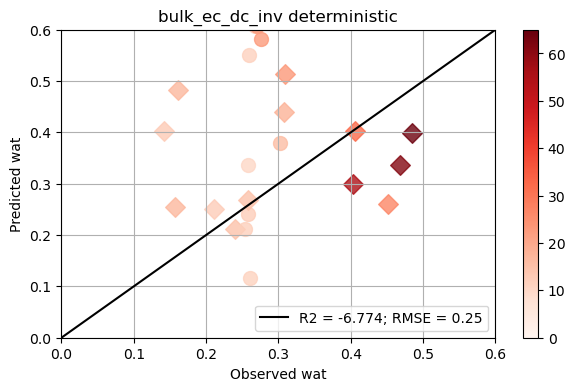

,Target,Best EC feature,R2
0,vwc,PRP0.6_DC,-0.686
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [12]:
feature_set = [
    'HCP0.5_DC_t',
    'HCP1.0_DC_t',
    'HCP2.0_DC_t',
    'PRP0.6_DC_t',
    'PRP1.1_DC_t',
    'PRP2.1_DC_t',
    'bulk_ec_dc_inv_t',

    'HCP0.5_DC',
    'HCP1.0_DC',
    'HCP2.0_DC',
    'PRP0.6_DC',
    'PRP1.1_DC',
    'PRP2.1_DC',
    'bulk_ec_dc_inv',
]

target = ds_all['vwc']
R2_, RMSE_, WAT_ = [], [], []

i = 0
for feature in feature_set:
    print(feature, ds_all[feature])
    title = feature+' deterministic'
    wat, r2, rmse = calculate_water(ds_all, feature)
    print('wat', wat)
    R2_.append(r2)
    RMSE_.append(rmse)
    WAT_.append(wat)

    best_index = R2_.index(np.max(R2_))

    R2_deterministic['R2'][0] = R2_[best_index]
    RMSE_deterministic['RMSE'][0] = RMSE_[best_index]
    R2_deterministic['Best EC feature'][0] = feature_set[best_index]
    RMSE_deterministic['Best EC feature'][0] = feature_set[best_index]
    R2_deterministic['Target'][0] = 'vwc'
    RMSE_deterministic['Target'][0] = 'vwc'

    print('for predicting water deterministically, the best predictor is:' +feature_set[best_index])

    plot_results(ds_all, target, wat, r2, rmse, ds_all.clay, title)

R2_deterministic

In [13]:
RMSE_deterministic

,Target,Best EC feature,RMSE
0,vwc,PRP0.6_DC,0.116
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


## Stochastic modelling (no layer distinction)

In [14]:
feature_sets = [
    ['HCP0.5'],
    ['HCP1.0'],
    ['HCP2.0'],
    ['HCP0.5', 'HCP1.0'],
    ['HCP0.5', 'HCP2.0'],
    ['HCP1.0', 'HCP2.0'],
#    ['HCP0.5', 'HCP1.0', 'HCP2.0'],
    ['PRP0.6'],
    ['PRP1.1'],
    ['PRP2.1'],
    ['PRP0.6', 'PRP1.1'],
    ['PRP0.6', 'PRP2.1'],
    ['PRP1.1', 'PRP2.1'],
#    ['PRP0.6', 'PRP1.1', 'PRP2.1'], 
    ['PRP0.6', 'HCP0.5'],
    ['bulk_ec_dc_inv'],
    ['bulk_ec_dc_inv_t']
#    ['bulk_ec_dc_inv', 'PRP0.6', 'HCP0.5']
]

In [15]:
def stochastic_poly(df, feature_columns, Y, n=4, iters=100, round_n=3):
    ypred_train_best, ypred_test_best, R2_train_t_best, R2_test_t_best, RMSE_train_t_best, RMSE_test_t_best = [], [], [], [], [], []
    X = df[feature_columns[0]].values.reshape(-1, 1)
    
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
        LinReg = LinearRegression()
        ypred_train_, ypred_test_, R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], [], [], []

        for k in range(n):
            poly = PolynomialFeatures(degree=k)
            poly.fit(X_train)
            Xt_train = poly.transform(X_train)
            Xt_test = poly.transform(X_test)

            LinReg.fit(Xt_train, y_train)
            ypred_train = LinReg.predict(Xt_train)
            ypred_test = LinReg.predict(Xt_test)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            ypred_train_.append(ypred_train)
            ypred_test_.append(ypred_test)
            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        ypred_train_best.append(ypred_train_)
        ypred_test_best.append(ypred_test_)
        R2_train_t_best.append(R2_train_t_)
        R2_test_t_best.append(R2_test_t_)
        RMSE_train_t_best.append(RMSE_train_t_)
        RMSE_test_t_best.append(RMSE_test_t_)

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_best]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_best]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_best]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_best]
    
    RMSE_sums = [np.mean(RMSE_test_n1), np.mean(RMSE_test_n2), np.mean(RMSE_test_n3), np.mean(RMSE_test_n4)]
    best_n = RMSE_sums.index(np.min(RMSE_sums))
    return best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_best]), round_n)         


def implementation(df, features, target, n):           
    # Create a polynomial regression model
    if isinstance(features, (list, tuple)):
        X = df[list(features)]
    else:
        X = df[features][:, np.newaxis]
    
    # Create a polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree=n), LinearRegression())
    model.fit(X, df[target])
    
    # Predict y values
    predictions = model.predict(X)
    
    # Compute R^2 and RMSE
    r2 = r2_score(df[target], predictions)
    rmse = RMSE(df[target], predictions)
    
    # For plotting purposes, we'll use the first feature in the list (or the only feature)
    primary_feature = features[0] if isinstance(features, (list, tuple)) else features
    x_fit = np.linspace(min(df[primary_feature]), max(df[primary_feature]), 500)
    
    # If multiple features, we need to ensure the shape of x_fit matches
    if isinstance(features, (list, tuple)) and len(features) > 1:
        X_fit = pd.DataFrame({feature: x_fit if feature == primary_feature else df[feature].values 
                              for feature in features})
    else:
        X_fit = x_fit[:, np.newaxis]
    
    y_fit = model.predict(X_fit)
    
    # Plotting
    plt.scatter(df[primary_feature], df[target], label='Data Points')
    
    # Plot points where df['depth'] == 50 with 'D' marker
    depth_mask = df['depth'] == 50
    plt.scatter(df[primary_feature][depth_mask], df[target][depth_mask], marker='D', label='Depth=50 Points')
    
    plt.plot(x_fit, y_fit, color='black', label=f'Polynomial (Degree {n}) Fit')
    plt.title(f'Polynomial Fit of Degree {n}\n$R^2$: {r2:.2f}, RMSE: {rmse:.2f}')
    plt.xlabel(primary_feature)
    plt.ylabel(target)
    plt.legend()
    plt.show()
    
    return model

i 0
for predicting stochastically vwc the best predictor is:PRP0.6


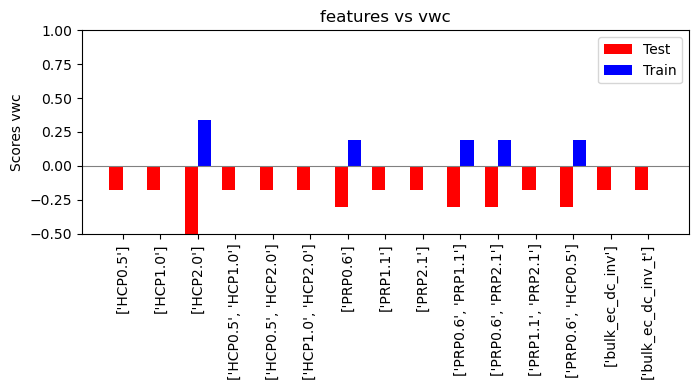

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


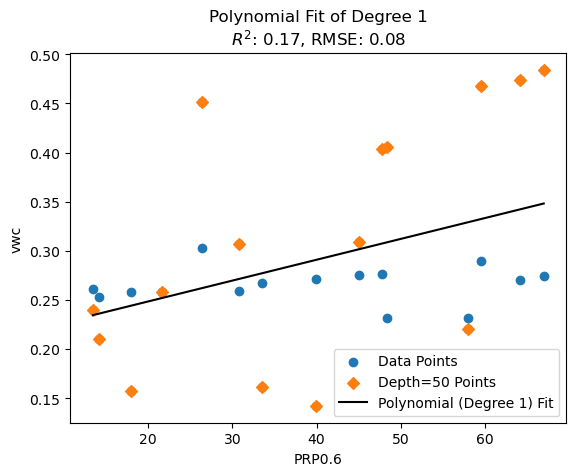

i 1
for predicting stochastically CEC the best predictor is:PRP0.6


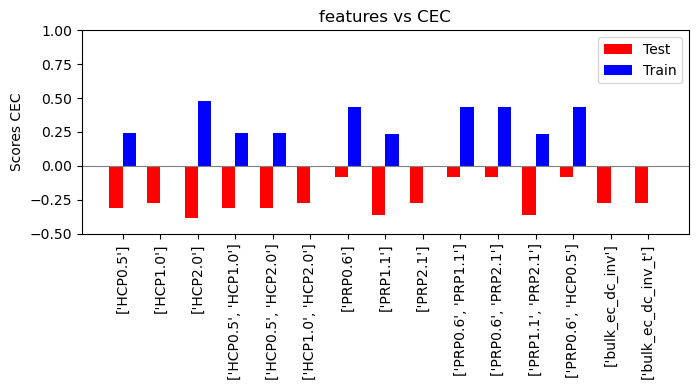

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


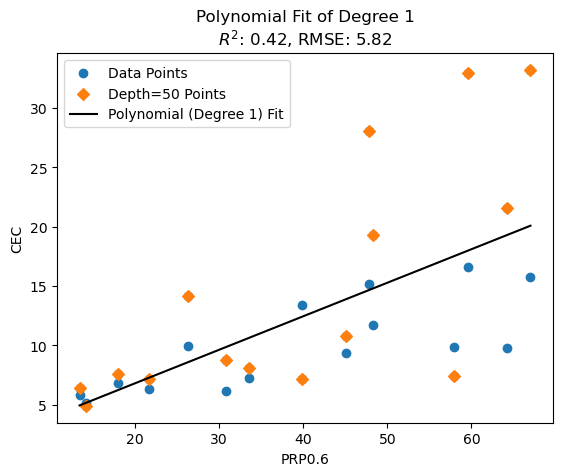

i 2
for predicting stochastically clay the best predictor is:PRP0.6


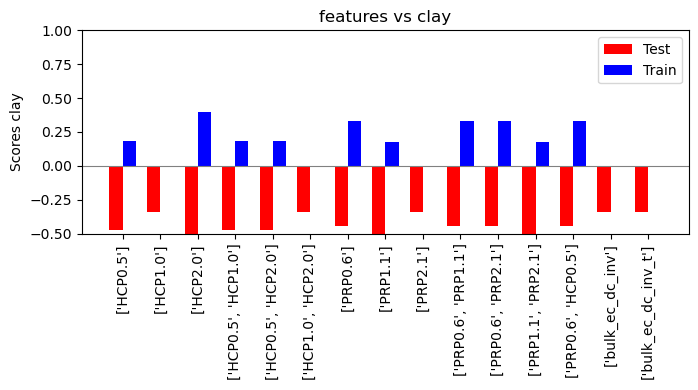

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


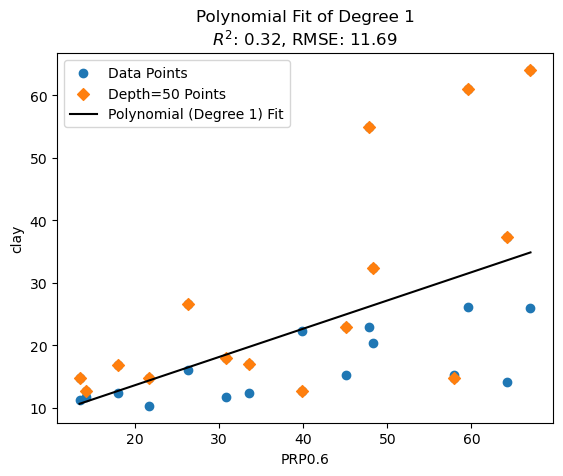

i 3
for predicting stochastically bd the best predictor is:PRP0.6


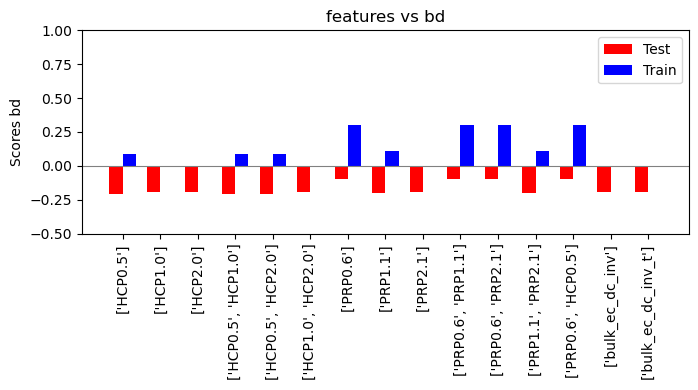

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


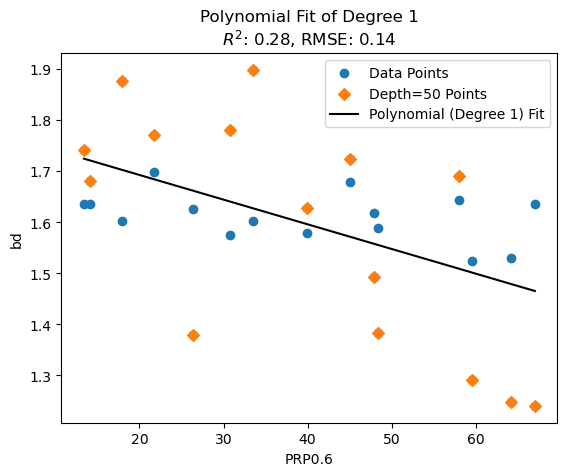

i 4
for predicting stochastically water_ec_hp_t the best predictor is:bulk_ec_dc_inv


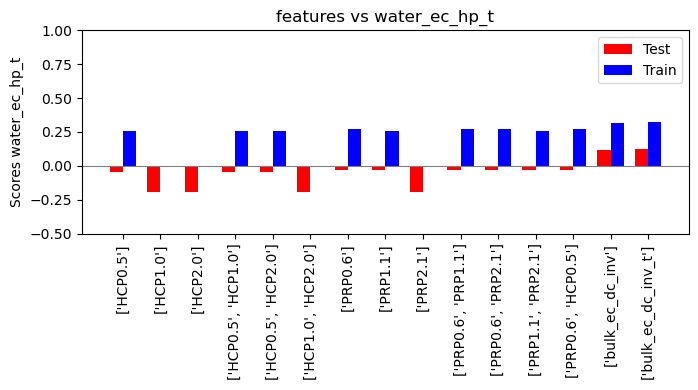

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


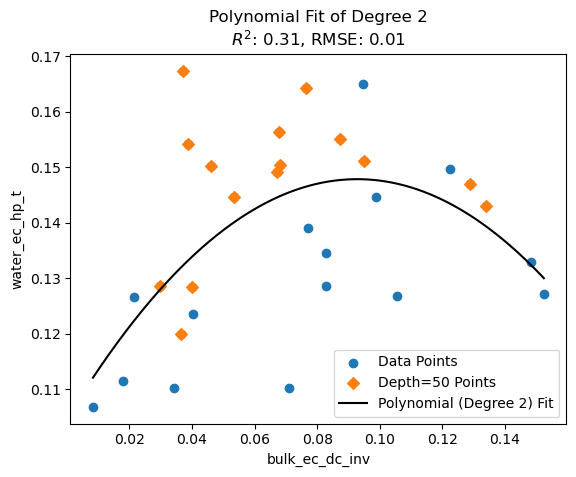

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature combined,R2 combined,R2 combined2
0,vwc,"(PRP0.6, 1)",-0.307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,"(PRP0.6, 1)",-0.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,"(PRP0.6, 1)",-0.445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,"(PRP0.6, 1)",-0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp_t,"(bulk_ec_dc_inv, 2)",0.113,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp_t'
]

i = 0
for t in target_set:
    print('i', i)
    R2_test, R2_train, RMSE_test, n_ = [], [], [], []
    target = ds_all[t].values
    
    for feature_set in feature_sets:        
        best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds_all, feature_set, target)
        #print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)
        RMSE_test.append(RMSE_test_pol)
        n_.append(best_n)

    best_index = RMSE_test.index(np.min(RMSE_test))
    n = n_[best_index]
    
    R2_stochastic['Best EC feature'][i] = (feature_sets[best_index][0], n)
    R2_stochastic['Target'][i] = t
    R2_stochastic['R2'][i] = R2_test[best_index]
    RMSE_stochastic['Best EC feature'][i] = (feature_sets[best_index][0], n)
    RMSE_stochastic['Target'][i] = t
    RMSE_stochastic['RMSE'][i] = RMSE_test[best_index]

    print('for predicting stochastically '+ t+' the best predictor is:' +feature_sets[best_index][0])
    bars_plot(feature_sets, R2_test, R2_train, t)
    implementation(ds_all, feature_sets[best_index], t, n)

    i+=1
R2_stochastic

In [17]:
RMSE_stochastic

,Target,Best EC feature,RMSE,Best EC feature 10cm,RMSE 10cm,Best EC feature 50cm,RMSE 50cm,Best EC feature combined,RMSE combined,RMSE combined2
0,vwc,"(PRP0.6, 1)",0.088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,"(PRP0.6, 1)",6.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,"(PRP0.6, 1)",12.271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,"(PRP0.6, 1)",0.148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp_t,"(bulk_ec_dc_inv, 2)",0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Layered stochastic modelling

In [18]:
def stochastic_poly_(df, feature_columns, target, n=4, iters=100, round_n=3):
    R2_train_t_10_, R2_test_t_10_, RMSE_train_t_10_, RMSE_test_t_10_, ypred_test_10_ = [], [], [], [], []
    R2_train_t_50_, R2_test_t_50_, RMSE_train_t_50_, RMSE_test_t_50_, ypred_test_50_ = [], [], [], [], []
    R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], []
    y_test_ = []

    for i in range(iters):

        X_layer_10 = df[df['depth'] == 10][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_10 = df[df['depth'] == 10][target].values

        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        R2_train_t_10, R2_test_t_10, RMSE_train_t_10, RMSE_test_t_10, ypred_test_10 = [], [], [], [], []
######
######
        X_layer_50 = df[df['depth'] == 50][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_50 = df[df['depth'] == 50][target].values

        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        R2_train_t_50, R2_test_t_50, RMSE_train_t_50, RMSE_test_t_50, ypred_test_50 = [], [], [], [], []
        
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50))
        y_test_.append(y_test)
        R2_train_t_comb, R2_test_t_comb, RMSE_train_t_comb, RMSE_test_t_comb = [], [], [], []
        
        for k in range(n):
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)

            LinReg10.fit(Xt_train10, y_train10)
            ypred_train10 = LinReg10.predict(Xt_train10)
            ypred_test10 = LinReg10.predict(Xt_test10)
            ypred_test_10.append(ypred_test10)

            R2_train_t10 = r2_score(y_train10, ypred_train10)
            R2_test_t10 = r2_score(y_test10, ypred_test10)
            RMSE_train_t10 = RMSE(y_train10, ypred_train10)
            RMSE_test_t10 = RMSE(y_test10, ypred_test10)

            R2_train_t_10.append(R2_train_t10)
            R2_test_t_10.append(R2_test_t10)
            RMSE_train_t_10.append(RMSE_train_t10)
            RMSE_test_t_10.append(RMSE_test_t10)

            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)

            LinReg50.fit(Xt_train50, y_train50)
            ypred_train50 = LinReg50.predict(Xt_train50)
            ypred_test50 = LinReg50.predict(Xt_test50)
            ypred_test_50.append(ypred_test50)

            ypred_train = np.concatenate((ypred_train10, ypred_train50))
            ypred_test = np.concatenate((ypred_test10, ypred_test50))

            R2_train_t50 = r2_score(y_train50, ypred_train50)
            R2_test_t50 = r2_score(y_test50, ypred_test50)
            RMSE_train_t50 = RMSE(y_train50, ypred_train50)
            RMSE_test_t50 = RMSE(y_test50, ypred_test50)

            R2_train_t_50.append(R2_train_t50)
            R2_test_t_50.append(R2_test_t50)
            RMSE_train_t_50.append(RMSE_train_t50)
            RMSE_test_t_50.append(RMSE_test_t50)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        R2_train_t_10_.append(R2_train_t_10)
        R2_test_t_10_.append(R2_test_t_10)
        RMSE_train_t_10_.append(RMSE_train_t_10)
        RMSE_test_t_10_.append(RMSE_test_t_10)
        ypred_test_10_.append(ypred_test_10)

        R2_train_t_50_.append(R2_train_t_50)
        R2_test_t_50_.append(R2_test_t_50)
        RMSE_train_t_50_.append(RMSE_train_t_50)
        RMSE_test_t_50_.append(RMSE_test_t_50)
        ypred_test_50_.append(ypred_test_50)

        R2_train_t_comb.append(R2_train_t_)
        R2_test_t_comb.append(R2_test_t_)
        RMSE_train_t_comb.append(RMSE_train_t_)
        RMSE_test_t_comb.append(RMSE_test_t_)

    RMSE_test_n1_10 = [inner_list[0] for inner_list in RMSE_test_t_10_]
    RMSE_test_n2_10 = [inner_list[1] for inner_list in RMSE_test_t_10_]
    RMSE_test_n3_10 = [inner_list[2] for inner_list in RMSE_test_t_10_]
    RMSE_test_n4_10 = [inner_list[3] for inner_list in RMSE_test_t_10_]

    RMSE_test_n1_50 = [inner_list[0] for inner_list in RMSE_test_t_50_]
    RMSE_test_n2_50 = [inner_list[1] for inner_list in RMSE_test_t_50_]
    RMSE_test_n3_50 = [inner_list[2] for inner_list in RMSE_test_t_50_]
    RMSE_test_n4_50 = [inner_list[3] for inner_list in RMSE_test_t_50_]

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_comb]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_comb]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_comb]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_comb]

    RMSE_mean_10 = [np.mean(RMSE_test_n1_10), np.mean(RMSE_test_n2_10), np.mean(RMSE_test_n3_10), np.mean(RMSE_test_n4_10)]
    best_n_10 = RMSE_mean_10.index(np.min(RMSE_mean_10))

    RMSE_mean_50 = [np.mean(RMSE_test_n1_50), np.mean(RMSE_test_n2_50), np.mean(RMSE_test_n3_50), np.mean(RMSE_test_n4_50)]
    best_n_50 = RMSE_mean_50.index(np.min(RMSE_mean_50))

    RMSE_mean = [np.mean(RMSE_test_n1), np.mean(RMSE_test_n2), np.mean(RMSE_test_n3), np.mean(RMSE_test_n4)]
    best_n = RMSE_mean.index(np.min(RMSE_mean))

    for j in range(iters):
        _10 = [inner_list[best_n_10] for inner_list in ypred_test_10_][j]
        _50 = [inner_list[best_n_50] for inner_list in ypred_test_50_][j]
        ypred_1050 = np.concatenate((_10, _50))

        ytest_1050 =  y_test_[j]

        R2_1050 = r2_score(ytest_1050, ypred_1050)
        RMSE_1050 = RMSE(ytest_1050, ypred_1050)

    return best_n_10, round(np.mean([inner_list[best_n_10] for inner_list in R2_test_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in R2_train_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in RMSE_test_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in RMSE_train_t_10_]), round_n), best_n_50, round(np.mean([inner_list[best_n_50] for inner_list in R2_test_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in R2_train_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in RMSE_test_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in RMSE_train_t_50_]), round_n), best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_comb]), round_n), round(R2_1050, round_n), round(RMSE_1050, round_n)   

Predicting stochastically vwc with combined layer modelling, the best predictor is: HCP2.0 with ply grade: 1


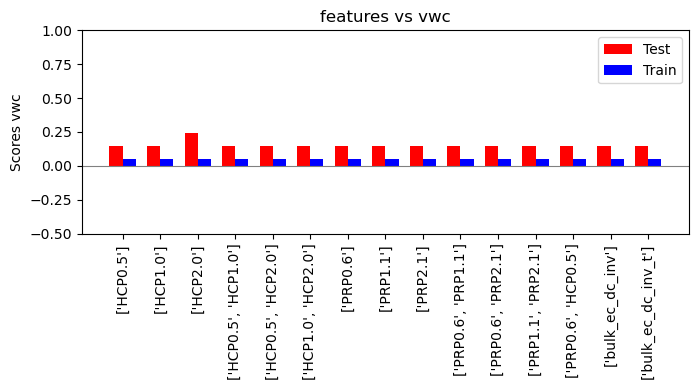

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


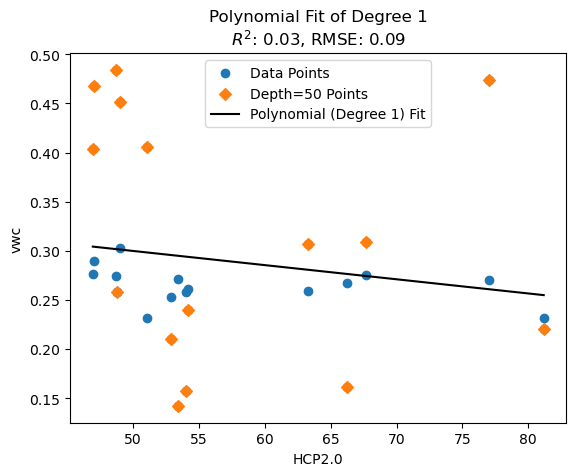

Predicting stochastically vwc for the 10 cm layer, the best predictor is: HCP0.5 with ply grade: 0


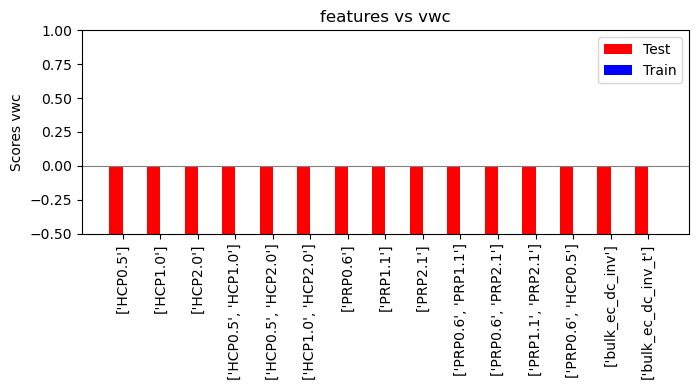

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


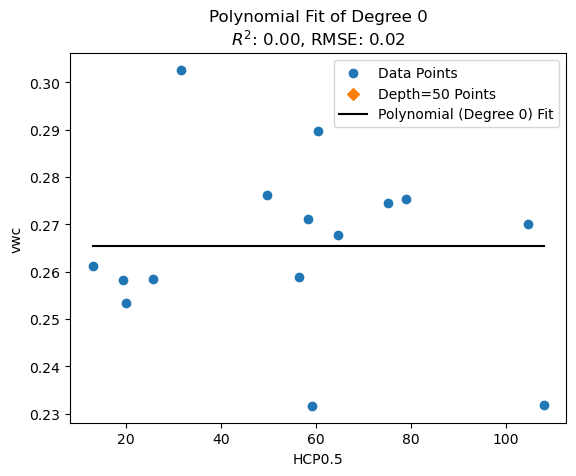

Predicting stochastically vwc for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


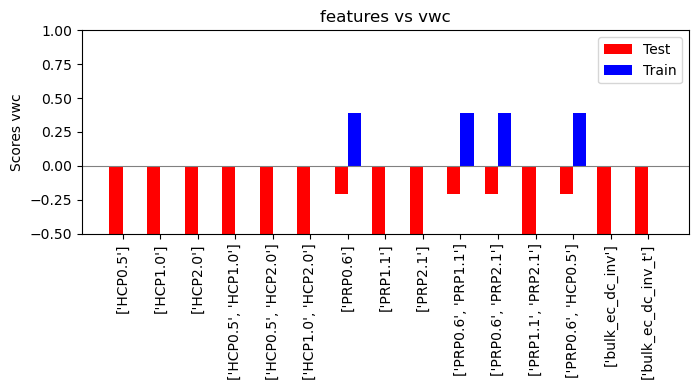

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


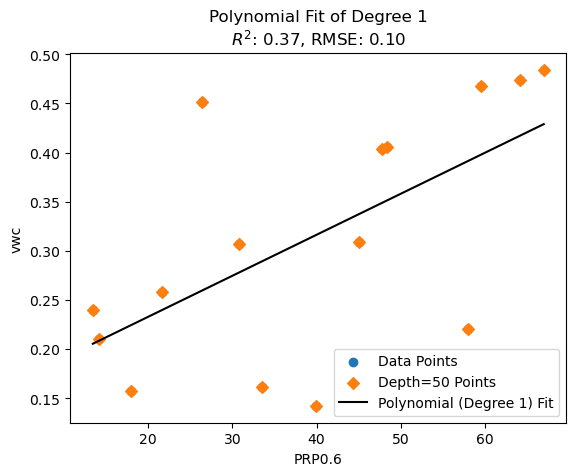

Predicting stochastically CEC with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 1


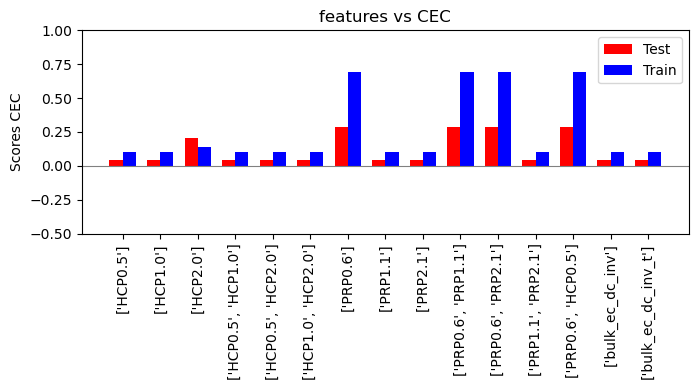

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


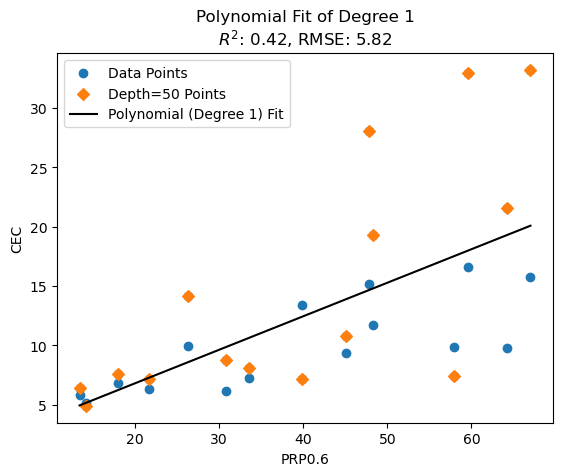

Predicting stochastically CEC for the 10 cm layer, the best predictor is: PRP0.6 with ply grade: 1


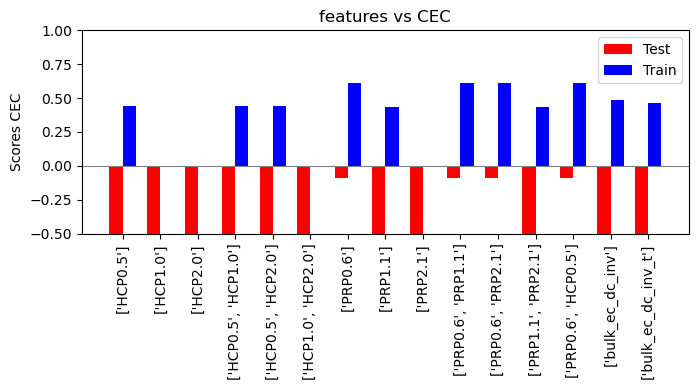

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


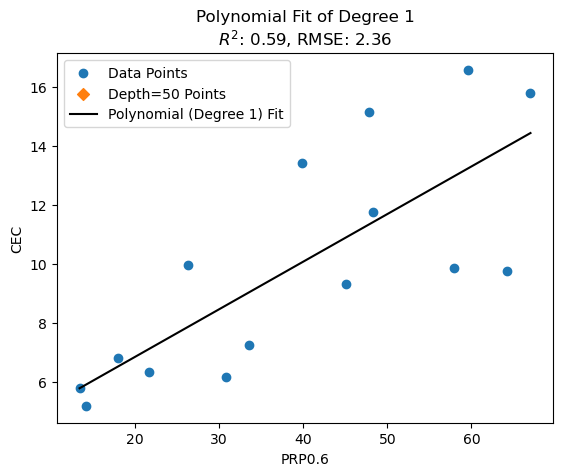

Predicting stochastically CEC for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


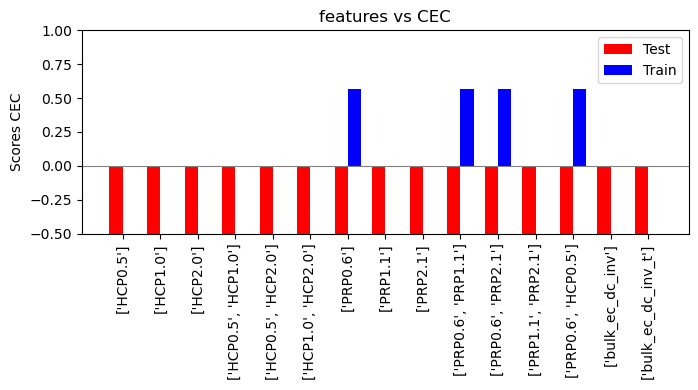

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


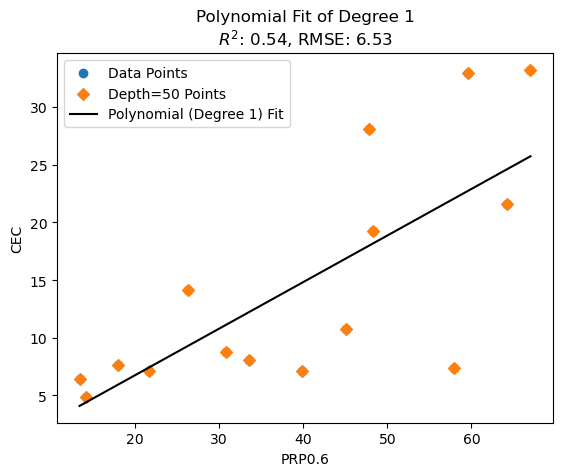

Predicting stochastically clay with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 2


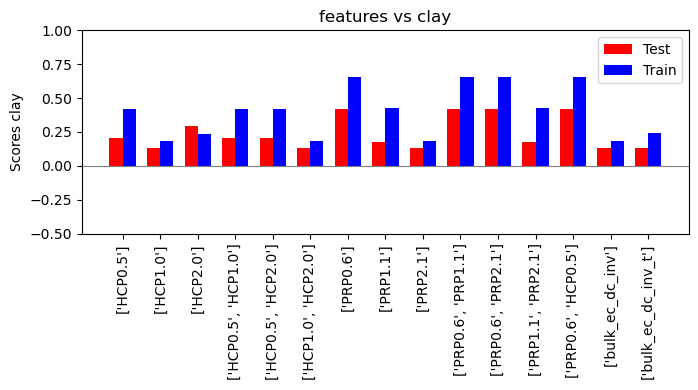

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


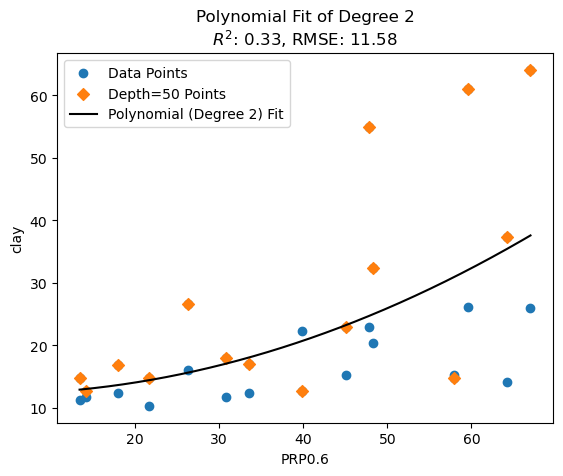

Predicting stochastically clay for the 10 cm layer, the best predictor is: PRP0.6 with ply grade: 1


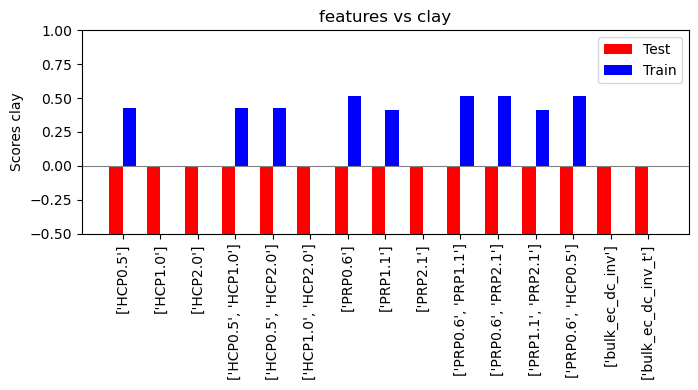

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


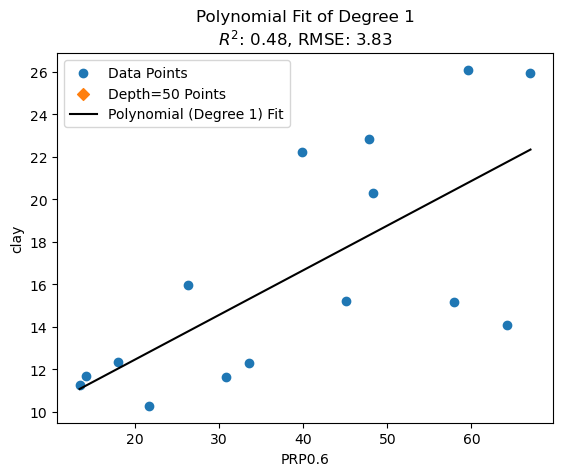

Predicting stochastically clay for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


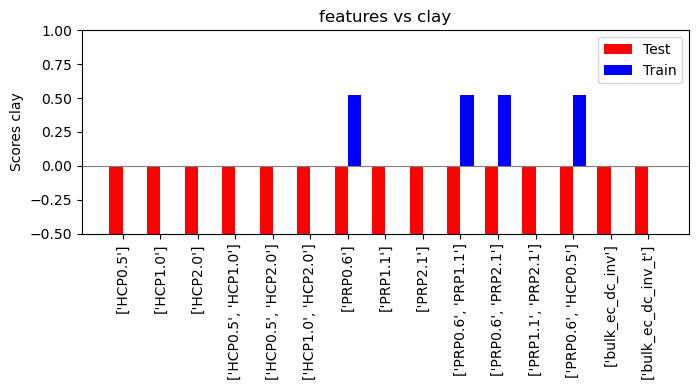

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


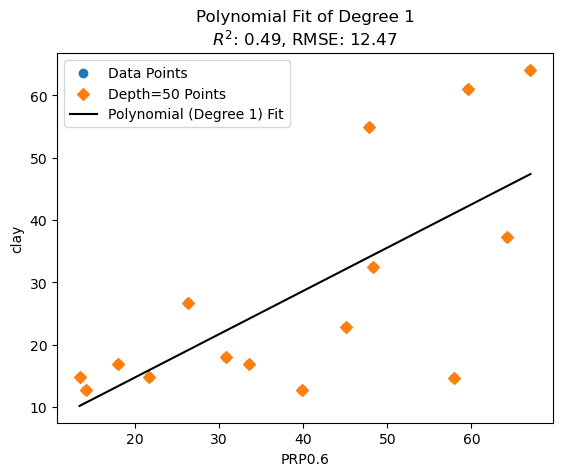

Predicting stochastically bd with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 2


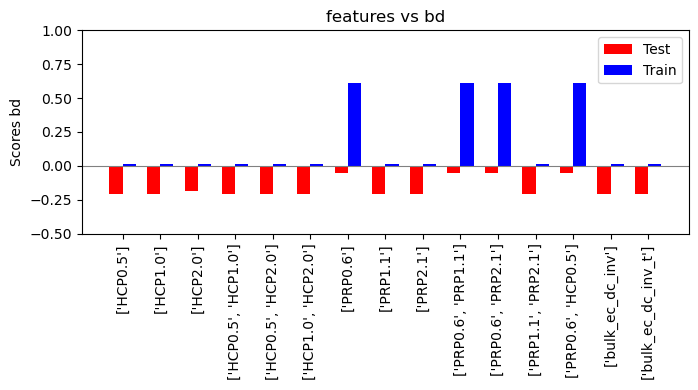

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


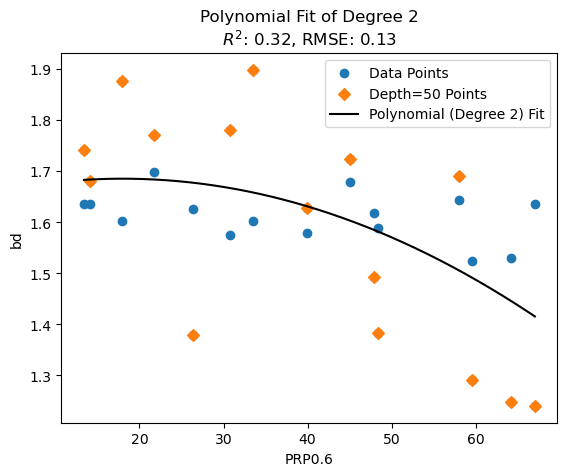

Predicting stochastically bd for the 10 cm layer, the best predictor is: HCP0.5 with ply grade: 0


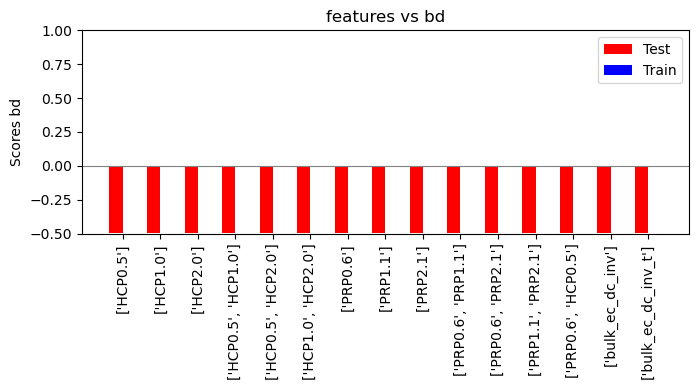

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


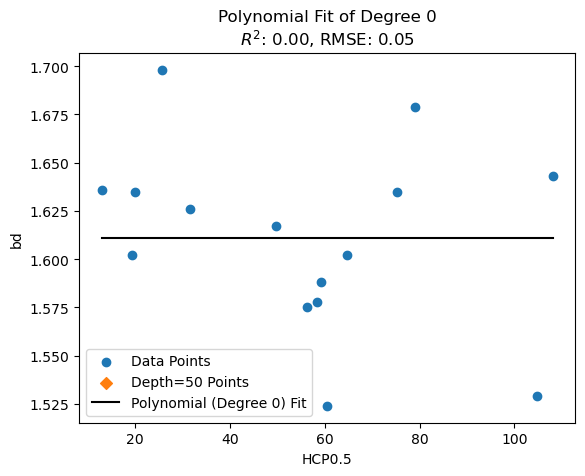

Predicting stochastically bd for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


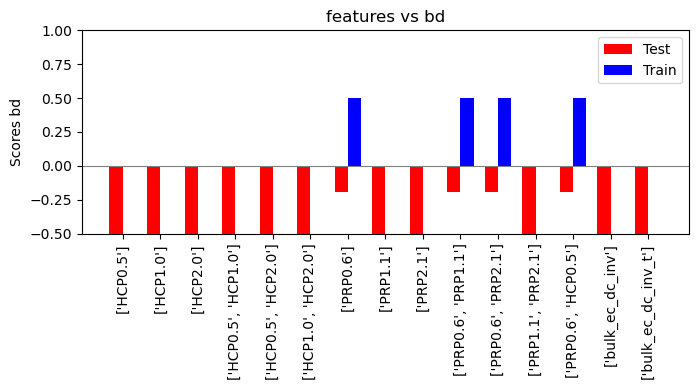

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


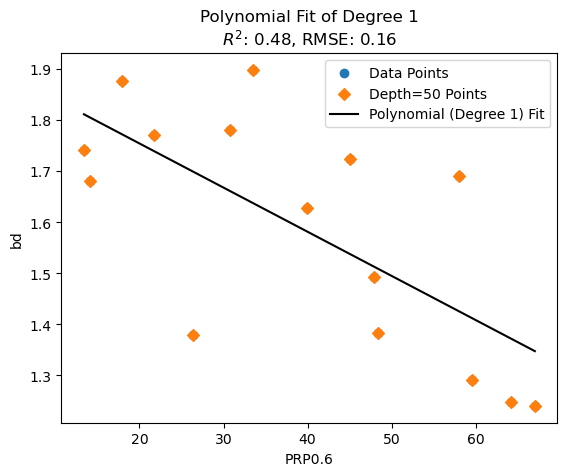

Predicting stochastically water_ec_hp_t with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 1


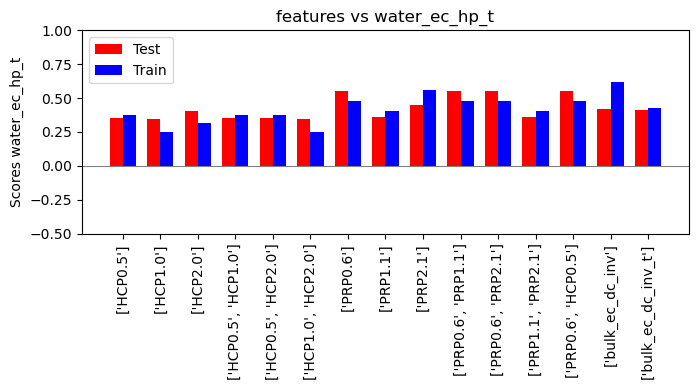

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


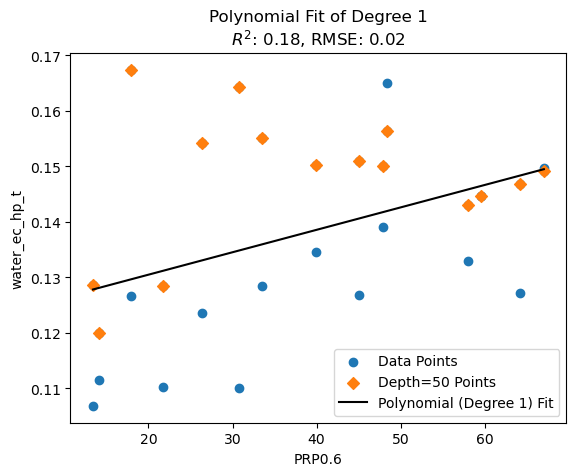

Predicting stochastically water_ec_hp_t for the 10 cm layer, the best predictor is: PRP0.6 with ply grade: 1


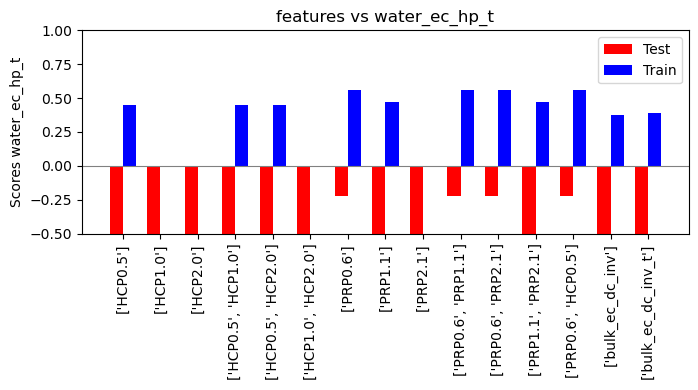

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


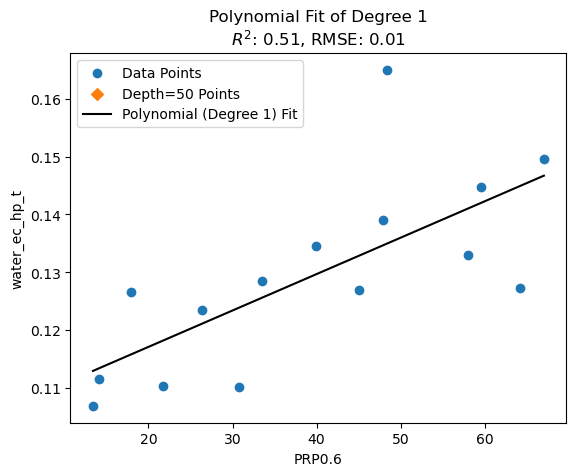

Predicting stochastically water_ec_hp_t for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 3


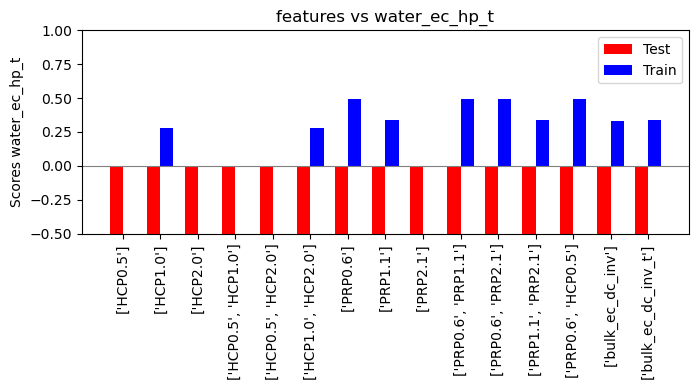

c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


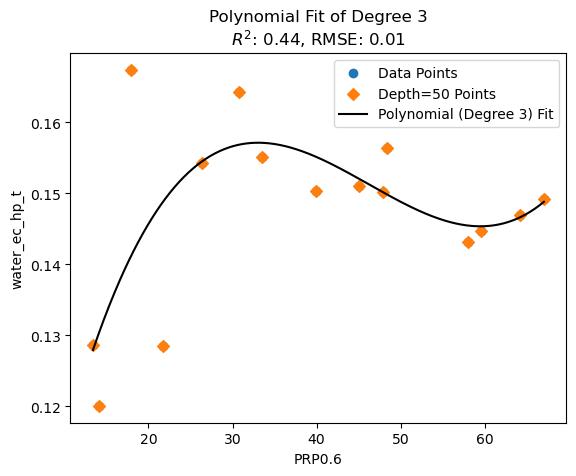

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature combined,R2 combined,R2 combined2
0,vwc,"(PRP0.6, 1)",-0.307,"([HCP0.5], 0)",-0.525,"([PRP0.6], 1)",-0.209,"([HCP2.0], 1)",0.243,-0.832
1,CEC,"(PRP0.6, 1)",-0.084,"([PRP0.6], 1)",-0.088,"([PRP0.6], 1)",-1.614,"([PRP0.6], 1)",0.285,-0.145
2,clay,"(PRP0.6, 1)",-0.445,"([PRP0.6], 1)",-1.028,"([PRP0.6], 1)",-1.842,"([PRP0.6], 2)",0.418,-0.056
3,bd,"(PRP0.6, 1)",-0.1,"([HCP0.5], 0)",-0.493,"([PRP0.6], 1)",-0.194,"([PRP0.6], 2)",-0.056,-0.966
4,water_ec_hp_t,"(bulk_ec_dc_inv, 2)",0.113,"([PRP0.6], 1)",-0.223,"([PRP0.6], 3)",-1.724,"([PRP0.6], 1)",0.552,0.668


In [19]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp_t'
]

i=0
for t in target_set:
    R2_test, R2_train, n_comb, RMSE_test = [], [], [], []
    R2_test_10, R2_train_10, n_10, RMSE_test_10 = [], [], [], []
    R2_test_50, R2_train_50, n_50, RMSE_test_50 = [], [], [], []
    R2_1050_, RMSE_1050_ = [], []

    target = ds_all[t].values

    for feature_set in feature_sets:        
        best_n_10, R2_test_pol_10, R2_train_pol_10, RMSE_test_pol_10, RMSE_train_pol_10, best_n_50, R2_test_pol_50, R2_train_pol_50, RMSE_test_pol_50, RMSE_train_pol_50, best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, R2_1050, RMSE_1050 = stochastic_poly_(ds_all, feature_set, t)
        
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)
        n_comb.append(best_n)
        RMSE_test.append(RMSE_test_pol)

        R2_test_10.append(R2_test_pol_10)
        R2_train_10.append(R2_train_pol_10)
        n_10.append(best_n_10)
        RMSE_test_10.append(RMSE_test_pol_10)

        R2_test_50.append(R2_test_pol_50)
        R2_train_50.append(R2_train_pol_50)
        n_50.append(best_n_50)
        RMSE_test_50.append(RMSE_test_pol_50)

        R2_1050_.append(R2_1050)
        RMSE_1050_.append(RMSE_1050)

    best_index = RMSE_test.index(np.min(RMSE_test))
    n_ = n_comb[best_index]
    R2_stochastic['Best EC feature combined'][i] = (feature_sets[best_index], n_)
    R2_stochastic['Target'][i] = t
    R2_stochastic['R2 combined'][i] = R2_test[best_index]
    RMSE_stochastic['Best EC feature combined'][i] = (feature_sets[best_index], n_)
    RMSE_stochastic['Target'][i] = t
    RMSE_stochastic['RMSE combined'][i] = RMSE_test[best_index]
    print('Predicting stochastically '+t+' with combined layer modelling, the best predictor is: ' +feature_sets[best_index][0]+' with ply grade: '+str(n_))
    bars_plot(feature_sets, R2_test, R2_train, t)
    implementation(ds_all, feature_sets[best_index], t, n_)

    best_index_10 = RMSE_test_10.index(np.min(RMSE_test_10))
    n_10_ = n_10[best_index_10]
    R2_stochastic['Best EC feature '+str(10)+'cm'][i] = (feature_sets[best_index_10], n_10_)
    R2_stochastic['R2 '+str(10)+'cm'][i] = R2_test_10[best_index_10]
    RMSE_stochastic['Best EC feature '+str(10)+'cm'][i] = (feature_sets[best_index_10], n_10_)
    RMSE_stochastic['RMSE '+str(10)+'cm'][i] = RMSE_test_10[best_index_10]
    print('Predicting stochastically '+t+' for the 10 cm layer, the best predictor is: ' +feature_sets[best_index_10][0]+' with ply grade: '+str(n_10_))
    bars_plot(feature_sets, R2_test_10, R2_train_10, t)
    implementation(ds_all[ds_all['depth'] == 10], feature_sets[best_index_10], t, n_10_)

    best_index_50 = RMSE_test_50.index(np.min(RMSE_test_50))
    n_50_ = n_50[best_index_50]
    R2_stochastic['Best EC feature '+str(50)+'cm'][i] = (feature_sets[best_index_50], n_50_)
    R2_stochastic['R2 '+str(50)+'cm'][i] = R2_test_50[best_index_50]
    RMSE_stochastic['Best EC feature '+str(50)+'cm'][i] = (feature_sets[best_index_50], n_50_)
    RMSE_stochastic['RMSE '+str(50)+'cm'][i] = RMSE_test_50[best_index_50]
    print('Predicting stochastically '+t+' for the 50 cm layer, the best predictor is: ' +feature_sets[best_index_50][0]+' with ply grade: '+str(n_50_))
    bars_plot(feature_sets, R2_test_50, R2_train_50, t)
    implementation(ds_all[ds_all['depth'] == 50], feature_sets[best_index_50], t, n_50_)

    best_index_1050 = R2_1050_.index(np.max(R2_1050_))
    R2_stochastic['R2 combined2'][i] = R2_1050_[best_index_1050]
    RMSE_stochastic['RMSE combined2'][i] = RMSE_1050_[best_index_1050]

    i+=1

R2_stochastic

In [20]:
RMSE_stochastic

,Target,Best EC feature,RMSE,Best EC feature 10cm,RMSE 10cm,Best EC feature 50cm,RMSE 50cm,Best EC feature combined,RMSE combined,RMSE combined2
0,vwc,"(PRP0.6, 1)",0.088,"([HCP0.5], 0)",0.02,"([PRP0.6], 1)",0.106,"([HCP2.0], 1)",0.061,0.088
1,CEC,"(PRP0.6, 1)",6.077,"([PRP0.6], 1)",2.785,"([PRP0.6], 1)",7.538,"([PRP0.6], 1)",6.528,6.918
2,clay,"(PRP0.6, 1)",12.271,"([PRP0.6], 1)",4.538,"([PRP0.6], 1)",14.373,"([PRP0.6], 2)",11.411,12.535
3,bd,"(PRP0.6, 1)",0.148,"([HCP0.5], 0)",0.048,"([PRP0.6], 1)",0.183,"([PRP0.6], 2)",0.151,0.088
4,water_ec_hp_t,"(bulk_ec_dc_inv, 2)",0.015,"([PRP0.6], 1)",0.013,"([PRP0.6], 3)",0.012,"([PRP0.6], 1)",0.011,0.007
